# One Queue or Two

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [3]:
# import functions from modsim

from modsim import *
import matplotlib.pyplot as plt


This notebook presents a case study from *Modeling and Simulation in Python*.  It explores a question related to queueing theory, which is the study of systems that involve waiting in lines, also known as "queues".

Suppose you are designing the checkout area for a new store.  There is room for two checkout counters and a waiting area for customers.  You can make two lines, one for each counter, or one line that serves both counters.

In theory, you might expect a single line to be better, but it has some practical drawbacks: in order to maintain a single line, you would have to install rope barriers, and customers might be put off by what seems to be a longer line, even if it moves faster.

So you'd like to check whether the single line is really better and by how much.  Simulation can help answer this question.

As we did in the bikeshare model, we'll assume that a customer is equally likely to arrive during any timestep.  I'll denote this probability using the Greek letter lambda, $\lambda$, or the variable name `lam`.  The value of $\lambda$ probably varies from day to day, so we'll have to consider a range of possibilities.

Based on data from other stores, you know that it takes 5 minutes for a customer to check out, on average.  But checkout times are highly variable: most customers take less than 5 minutes, but some take substantially more.  A simple way to model this variability is to assume that when a customer is checking out, they have the same probability of finishing up during each time step.  I'll denote this probability using the Greek letter mu, $\mu$, or the variable name `mu`.

If we choose $\mu=1/5$, the average number of time steps for each checkout will be 5 minutes, which is consistent with the data.

## One server, one queue

Write a function called `make_system` that takes `lam` and `mu` as parameters and returns a `System` object with variables `lam`, `mu`, and `duration`.  Set `duration`, which is the number of time steps to simulate, to 10 hours, expressed in minutes. 

In [8]:
def make_system(lam, mu):
  """ lam - a customer arrival rate
      mu - process rate"""

  return System(lam=lam, mu=mu, duration=600)

Test this function by creating a `System` object with `lam=1/8` and `mu=1/5`.

In [9]:
interarrival_time = 8
service_time = 5

lam = 1/interarrival_time
mu = 1/service_time

system1 = make_system(lam=lam, mu=mu)
system1

System(duration=600, lam=0.125, mu=0.2)

Write an update function that takes as parameters `x`, which is the total number of customer in the store, including the one checking out; `t`, which is the number of minutes that have elapsed in the simulation, and `system`, which is a `System` object.

If there's a customer checking out, it should use `flip` to decide whether they are done.  And it should use `flip` to decide if a new customer has arrived.

It should return the total number of customers at the end of the time step.

In [12]:
def update_func(x, t, system):

  """ Check if the customers are done at check out"""
  if x > 0:
    if flip(system.mu):
      x -= 1
  
  if flip(system.lam):
    x += 1

  return x

Test your function by calling it with `x=1`, `t=0`, and the `System` object you created.  If you run it a few times, you should see different results.

In [13]:
update_func(1,0,system1)

0

Now we can run the simulation.  Here's a version of `run_simulation` that creates a `TimeSeries` with the total number of customers in the store, including the one checking out.

In [14]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x = 0
    results = TimeSeries()
    results[0] = x
    
    for t in linrange(0, system.duration):
        x = update_func(x, t, system)
        results[t+1] = x

    return results

Call `run_simulation` with your update function and plot the results.

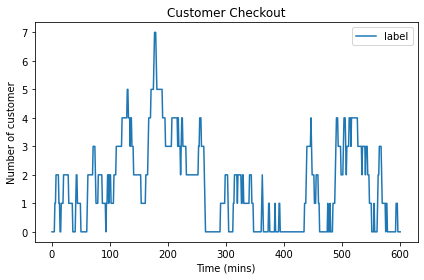

In [17]:
results1 = run_simulation(system1, update_func)
#results1.plot(label='results1')
plt.plot(results1, label='label')
decorate(title='Customer Checkout',
         xlabel='Time (mins)',
         ylabel='Number of customer')

After the simulation, we can compute `L`, which is the average number of customers in the system, and `W`, which is the average time customers spend in the store.  `L` and `W` are related by Little's Law:

$L = \lambda W$

Where $\lambda$ is the arrival rate.  Here's a function that computes them.

In [18]:
def compute_metrics(results, system):
    """Compute average number of customers and wait time.
    
    results: TimeSeries of queue lengths
    system: System object
    
    returns: L, W
    """
    L = results.mean()
    W = L / system.lam
    return L, W

Call `compute_metrics` with the results from your simulation.

In [19]:
L, W = compute_metrics(results1, system1)
print(L,W)

1.649501661129568 13.196013289036545


### Parameter sweep

Since we don't know the actual value of $\lambda$, we can sweep through a range of possibilities, from 10% to 80% of the completion rate, $\mu$.  (If customers arrive faster than the completion rate, the queue grows without bound.  In that case the metrics `L` and `W` just depend on how long the store is open.)

Create an array of values for `lam`.

In [24]:
lam_array = linspace(0.1*mu, 0.8*mu, 101)
lam_array

array([0.02  , 0.0214, 0.0228, 0.0242, 0.0256, 0.027 , 0.0284, 0.0298,
       0.0312, 0.0326, 0.034 , 0.0354, 0.0368, 0.0382, 0.0396, 0.041 ,
       0.0424, 0.0438, 0.0452, 0.0466, 0.048 , 0.0494, 0.0508, 0.0522,
       0.0536, 0.055 , 0.0564, 0.0578, 0.0592, 0.0606, 0.062 , 0.0634,
       0.0648, 0.0662, 0.0676, 0.069 , 0.0704, 0.0718, 0.0732, 0.0746,
       0.076 , 0.0774, 0.0788, 0.0802, 0.0816, 0.083 , 0.0844, 0.0858,
       0.0872, 0.0886, 0.09  , 0.0914, 0.0928, 0.0942, 0.0956, 0.097 ,
       0.0984, 0.0998, 0.1012, 0.1026, 0.104 , 0.1054, 0.1068, 0.1082,
       0.1096, 0.111 , 0.1124, 0.1138, 0.1152, 0.1166, 0.118 , 0.1194,
       0.1208, 0.1222, 0.1236, 0.125 , 0.1264, 0.1278, 0.1292, 0.1306,
       0.132 , 0.1334, 0.1348, 0.1362, 0.1376, 0.139 , 0.1404, 0.1418,
       0.1432, 0.1446, 0.146 , 0.1474, 0.1488, 0.1502, 0.1516, 0.153 ,
       0.1544, 0.1558, 0.1572, 0.1586, 0.16  ])

Write a function that takes an array of values for `lam`, a single value for `mu`, and an update function.

For each value of `lam`, it should run a simulation, compute `L` and `W`, and store the value of `W` in a `SweepSeries`.

It should return the `SweepSeries`.

In [27]:
def sweep_lam(lam_array, mu, update_func):

  sweep = SweepSeries()
  """mu = 1/5
  """

  for lam in lam_array:
    system = make_system(lam, mu) 
    results = run_simulation(system, update_func)
    L, W=compute_metrics(results, system)
    sweep[lam]=W
  
  return sweep


Call your function to generate a `SweepSeries`, and plot it.

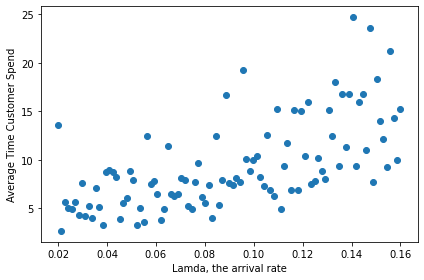

In [34]:
sweep1 = sweep_lam(lam_array, mu, update_func)
plt.scatter(sweep1.index, sweep1)
decorate(xlabel='Lamda, the arrival rate',
         ylabel='Average Time Customer Spend')


In [31]:
print(sweep1)

Parameter
0.0200     5.813953
0.0214     3.104915
0.0228     5.245672
0.0242     7.962439
0.0256     1.881748
            ...    
0.1544    16.761916
0.1558    15.193258
0.1572     6.688900
0.1586    12.830288
0.1600    20.691445
Name: Metric, Length: 101, dtype: float64


If we imagine that this range of values represents arrival rates on different days, we can use the average value of `W`, for a range of values of `lam`, to compare different queueing strategies.

In [36]:
sweep1.mean()

9.373991989329657

### Analysis

The model I chose for this system is a common model in queueing theory, in part because many of its properties can be derived analytically.

In particular, we can derive the average time in the store as a function of $\mu$ and $\lambda$:

$W = 1 / (\mu - \lambda)$

The following function plots the theoretical value of $W$ as a function of $\lambda$.

In [38]:
def plot_W(lam_array, mu):
    """Plot the theoretical mean wait time.
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    """
    W_array = 1 / (mu - lam_array)
    W_series = make_series(lam_array, W_array)
    W_series.plot(style='-', label='analysis')

Use this function to plot the theoretical results, then plot your simulation results again on the same graph.  How do they compare?

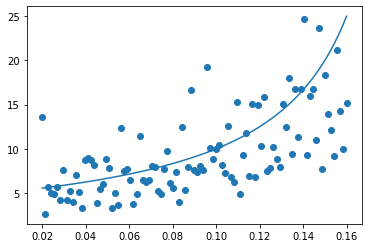

In [39]:
plot_W(lam_array, mu)
plt.scatter(sweep1.index, sweep1)

## Multiple servers

Now let's try the other two queueing strategies:

1.  One queue with two checkout counters.
2.  Two queues, one for each counter.

The following figure shows the three scenarios:

![](https://github.com/AllenDowney/ModSim/raw/main/figs/queue.png)

Write an update function for one queue with two servers.

In [41]:
""" 
x - the total number of customer in the store, including the one checking out
t - the number of minutes that have elapsed in the simulation
"""

def update_func1(x, t, system):
            
  """ Check if the customers are done at check out"""
  # if both servers are busy, check whether the
  # second is complete
  
  if x > 1:
    if flip(system.mu):
      x -= 1
  
  # check whether the first is complete
  if x > 0:
    if flip(system.mu):
      x -= 1
  
  if flip(system.lam):
    x += 1

  return x

Use this update function to simulate the system, plot the results, and print the metrics.

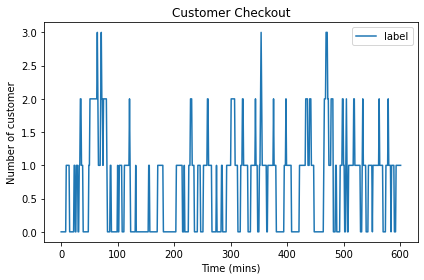

In [42]:
results2 = run_simulation(system1, update_func1)
#results1.plot(label='results1')
plt.plot(results2, label='label')
decorate(title='Customer Checkout',
         xlabel='Time (mins)',
         ylabel='Number of customer')

Since we have two checkout counters now, we can consider values for $\lambda$ that exceed $\mu$.

Create a new array of values for `lam` from 10% to 160% of `mu`.

In [ ]:
# Solution goes here

Use your sweep function to simulate the two server, one queue scenario with a range of values for `lam`.

Plot the results and print the average value of `W` across all values of `lam`.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

## Multiple queues

To simulate the scenario with two separate queues, we need two state variables to keep track of customers in each queue.

Write an update function that takes `x1`, `x2`, `t`, and `system` as parameters and returns `x1` and `x2` as return values.  f you are not sure how to return more than one return value, see `compute_metrics`.

When a customer arrives, which queue do they join?

In [ ]:
# Solution goes here

Write a version of `run_simulation` that works with this update function.

In [ ]:
# Solution goes here

Test your functions by running a simulation with a single value of `lam`.

In [ ]:
# Solution goes here

Sweep a range of values for `lam`, plot the results, and print the average wait time across all values of `lam`.

How do the results compare to the scenario with two servers and one queue.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here